In [1]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [28]:
# new matrices for nilearn connectome

import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = ['sub-107']  # temporary checking the matrix for one subject

run_num = 3
runs = list(range(1, run_num + 1))

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using MSDL atlas"""
    logging.info(f"Processing subject: {ss}")
    
    # Load MSDL atlas
    atlas = datasets.fetch_atlas_msdl()
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the MSDL atlas
        masker = NiftiMapsMasker(
            maps_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save with MSDL suffix
            output_dir = f'{results_dir}/connectivity_matrices_MSDL'
            os.makedirs(output_dir, exist_ok=True)
            output_path = f'{output_dir}/{ss}_connectivity_matrix_MSDL.npy'
            np.save(output_path, connectivity_matrix)
            logging.info(f'Saved MSDL connectivity matrix for {ss} at {output_path}')
            
            # Print matrix shape for verification
            logging.info(f'Matrix shape: {connectivity_matrix.shape}')  # Should be (39, 39) for MSDL

if __name__ == "__main__":
    main()

2024-11-11 14:52:11,866 - INFO - Processing subject: sub-107



Dataset created in /home/csimmon2/nilearn_data/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from /home/csimmon2/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/maskers/base_masker.py:253: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/maskers/base_masker.py:253: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(
2024-11-11 14:53:30,693 - INFO - Saved MSDL connectivity matrix for sub-107 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-107_connectivity_matrix_MSDL.npy
2024-11-11 14:53:30,695 - INFO - Matrix shape: (39, 39)


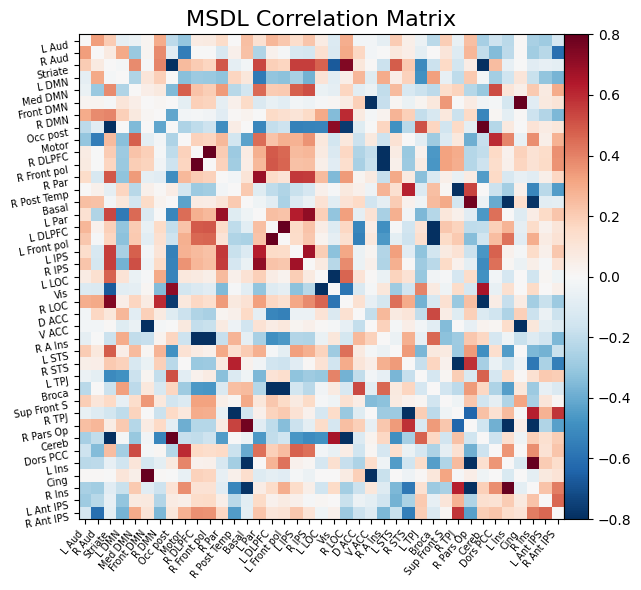

<Figure size 800x600 with 0 Axes>

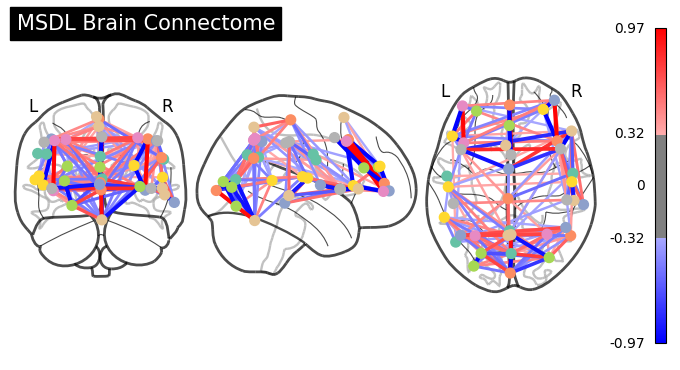


Connectivity Matrix Statistics:
Shape: (39, 39)
Value range: [-0.973, 1.000]
Number of regions: 39

Strongest connections:
Broca <-> L Front pol: -0.973
R A Ins <-> R Front pol: -0.973
R Front pol <-> R A Ins: -0.973
Front DMN <-> V ACC: -0.973
V ACC <-> Front DMN: -0.973


In [32]:
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt

# Load your saved matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-107_connectivity_matrix_MSDL.npy'
correlation_matrix = np.load(matrix_path)

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

# Create figure with a specific size
fig = plt.figure(figsize=(15, 6))

# Plot 1: Correlation Matrix
ax1 = plt.subplot(121)
matrix_plot = correlation_matrix.copy()
np.fill_diagonal(matrix_plot, 0)

plotting.plot_matrix(
    matrix_plot,
    labels=labels,
    colorbar=True,
    vmax=0.8,
    vmin=-0.8,
    title='MSDL Correlation Matrix',
    axes=ax1
)

# Plot 2: Brain Connectome
# Create a separate figure for the connectome
fig_connectome = plt.figure(figsize=(8, 6))
display = plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold="80%",
    node_color='auto',
    colorbar=True,
    title='MSDL Brain Connectome',
    display_mode='ortho'
)

# Show the plots
plt.show()

# Optional: Create an interactive 3D view
view = plotting.view_connectome(
    correlation_matrix,
    coords,
    edge_threshold="0%"
)

view.open_in_browser()

# Print connectivity statistics
print("\nConnectivity Matrix Statistics:")
print(f"Shape: {correlation_matrix.shape}")
print(f"Value range: [{correlation_matrix.min():.3f}, {correlation_matrix.max():.3f}]")
print(f"Number of regions: {len(labels)}")
print("\nStrongest connections:")
np.fill_diagonal(correlation_matrix, 0)
flat_indices = np.argsort(np.abs(correlation_matrix.flatten()))[-5:]
for idx in flat_indices:
    i, j = np.unravel_index(idx, correlation_matrix.shape)
    print(f"{labels[i]} <-> {labels[j]}: {correlation_matrix[i,j]:.3f}")

<Figure size 2000x1000 with 0 Axes>

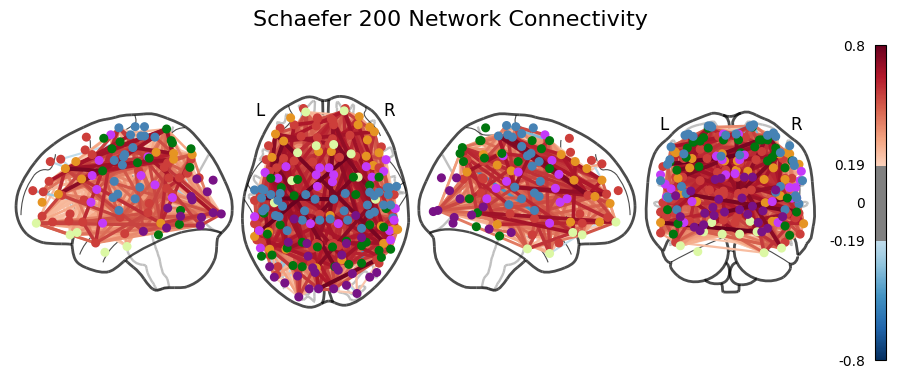

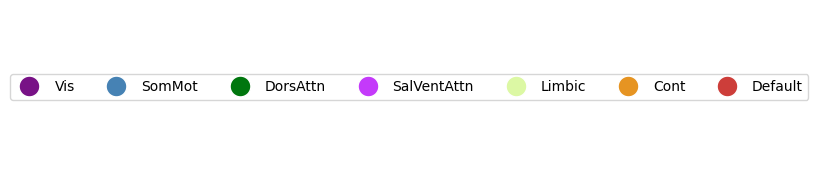


Network Distribution:
Vis: 25 ROIs
SomMot: 37 ROIs
DorsAttn: 31 ROIs
SalVentAttn: 22 ROIs
Limbic: 10 ROIs
Cont: 25 ROIs
Default: 50 ROIs

Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
7networks_RH_DorsAttn_TempOcc_4 <-> 7networks_LH_Vis_Striate_2: 0.776
7networks_RH_Limbic_OFC_2 <-> 7networks_LH_Cont_Temp: 0.791
7networks_LH_Cont_Temp <-> 7networks_RH_Limbic_OFC_2: 0.791
7networks_LH_SomMot_12 <-> 7networks_RH_SomMot_5: 0.792
7networks_RH_SomMot_5 <-> 7networks_LH_SomMot_12: 0.792


In [41]:
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates from saved file
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_1mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Define network colors (Yeo7 standard colors)
network_colors = {
    'Vis': '#781286',       # Purple
    'SomMot': '#4682B4',    # Blue
    'DorsAttn': '#00760E',  # Green
    'SalVentAttn': '#C43AFA',  # Magenta
    'Limbic': '#DCF8A4',    # Light green/yellow
    'Cont': '#E69422',      # Orange
    'Default': '#CD3E3A'    # Red
}

# Extract network names from ROI names and map to colors
network_names = [name.split('_')[2] for name in coords_df['ROI Name']]
node_colors = [network_colors[network] for network in network_names]

# Create connectome plot
plt.figure(figsize=(20, 10))
display = plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='90%',  # Showing more connections for better visualization
    node_size=30,
    node_color=node_colors,
    display_mode='lzry',   # Multiple views
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'     # Red-Blue colormap for negative-positive correlations
)
plt.suptitle('Schaefer 200 Network Connectivity', fontsize=16, y=1.05)

# Add legend
legend_fig = plt.figure(figsize=(10, 2))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=network, markersize=15)
                  for network, color in network_colors.items()]
plt.legend(handles=legend_elements, loc='center', ncol=7)
plt.axis('off')
plt.show()

# Print network statistics
print("\nNetwork Distribution:")
for network in network_colors.keys():
    count = sum(1 for name in network_names if name == network)
    print(f"{network}: {count} ROIs")

print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"{coords_df['ROI Name'][i]} <-> {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

<Figure size 1000x800 with 0 Axes>

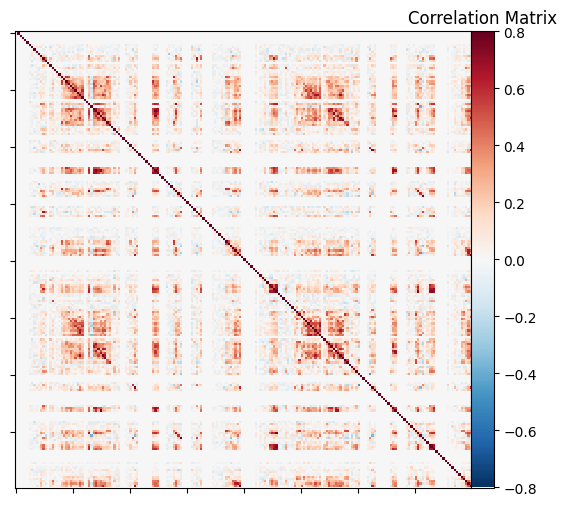

<Figure size 1500x800 with 0 Axes>

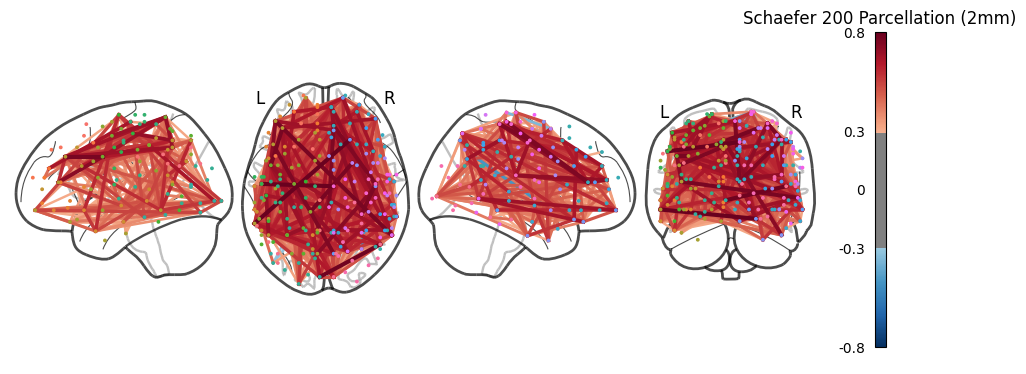


Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
ROI 7networks_RH_DorsAttn_TempOcc_4 <-> ROI 7networks_LH_Vis_Striate_2: 0.776
ROI 7networks_RH_Limbic_OFC_2 <-> ROI 7networks_LH_Cont_Temp: 0.791
ROI 7networks_LH_Cont_Temp <-> ROI 7networks_RH_Limbic_OFC_2: 0.791
ROI 7networks_LH_SomMot_12 <-> ROI 7networks_RH_SomMot_5: 0.792
ROI 7networks_RH_SomMot_5 <-> ROI 7networks_LH_SomMot_12: 0.792


In [53]:
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates with the correct 2mm path
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Generate random colors
node_colors = sns.color_palette('husl', n_colors=200)

# Create two separate figures for better control
# Figure 1: Matrix
plt.figure(figsize=(10, 8))
plotting.plot_matrix(
    correlation_matrix,
    colorbar=True,
    vmax=0.8,
    vmin=-0.8,
    cmap='RdBu_r'
)
plt.title('Correlation Matrix')
plt.show()

# Figure 2: Brain Connectome
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='95%',
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Schaefer 200 Parcellation (2mm)')
plt.show()

# Print statistics
print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"ROI {coords_df['ROI Name'][i]} <-> ROI {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

<Figure size 1500x800 with 0 Axes>

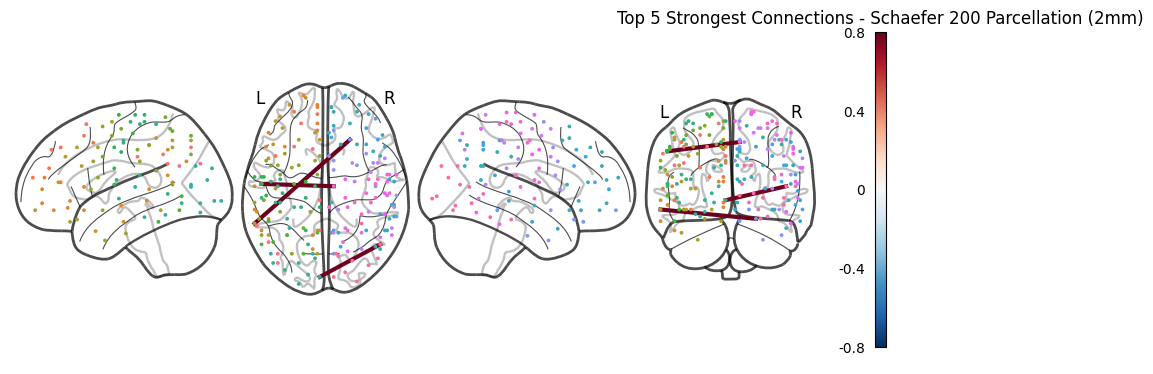


Top 5 Strongest Connections:
ROI 7networks_RH_DorsAttn_TempOcc_4 <-> ROI 7networks_LH_Vis_Striate_2: 0.776
ROI 7networks_LH_Cont_Temp <-> ROI 7networks_RH_Limbic_OFC_2: 0.791
ROI 7networks_RH_Limbic_OFC_2 <-> ROI 7networks_LH_Cont_Temp: 0.791
ROI 7networks_RH_SomMot_5 <-> ROI 7networks_LH_SomMot_12: 0.792
ROI 7networks_LH_SomMot_12 <-> ROI 7networks_RH_SomMot_5: 0.792


In [54]:
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates with the correct 2mm path
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Generate random colors
node_colors = sns.color_palette('husl', n_colors=200)

# Create a mask for the top 5 connections
# First, make a copy and set diagonal to 0
matrix_for_mask = correlation_matrix.copy()
np.fill_diagonal(matrix_for_mask, 0)

# Find the indices of the top 5 strongest connections
top_5_flat_indices = np.argsort(np.abs(matrix_for_mask.ravel()))[-5:]
top_5_indices = np.unravel_index(top_5_flat_indices, matrix_for_mask.shape)

# Create a mask matrix of zeros
mask_matrix = np.zeros_like(correlation_matrix)
mask_matrix[top_5_indices] = correlation_matrix[top_5_indices]

# Make it symmetric (since the connections are undirected)
mask_matrix = np.maximum(mask_matrix, mask_matrix.T)

# Plot the top 5 connections
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    mask_matrix,
    coords,
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Top 5 Strongest Connections - Schaefer 200 Parcellation (2mm)')
plt.show()

# Print the top 5 connections
print("\nTop 5 Strongest Connections:")
for idx in range(5):
    i, j = top_5_indices[0][idx], top_5_indices[1][idx]
    if i != j:  # Skip diagonal
        print(f"ROI {coords_df['ROI Name'][i]} <-> ROI {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

In [ ]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*[!glasser]_connectivity_matrix.npy') #!glasser to exclude glasser matrices
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Now you can proceed with the visualization functions

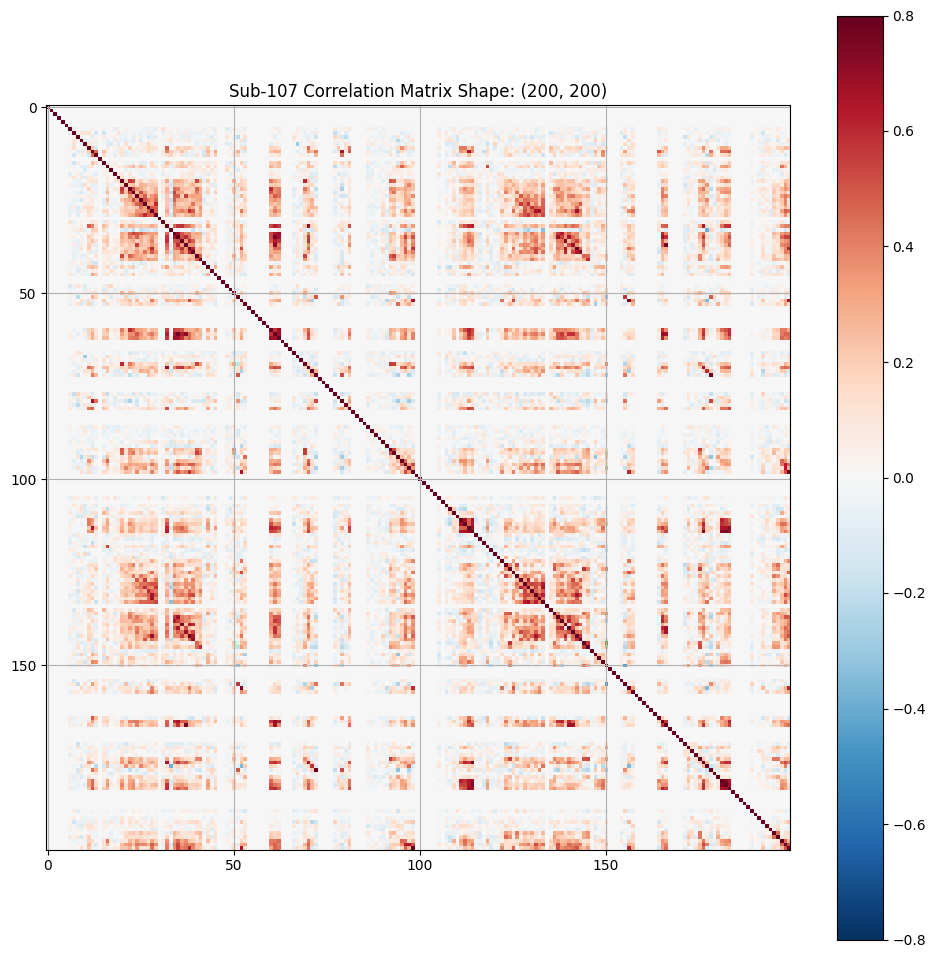


Connectivity Statistics for Sub-107:
Number of regions: 200
Total possible connections: 19900
Connections above 80th percentile threshold (0.000): 10685
Percentage of strong connections: 53.69%


<Figure size 1000x1000 with 0 Axes>

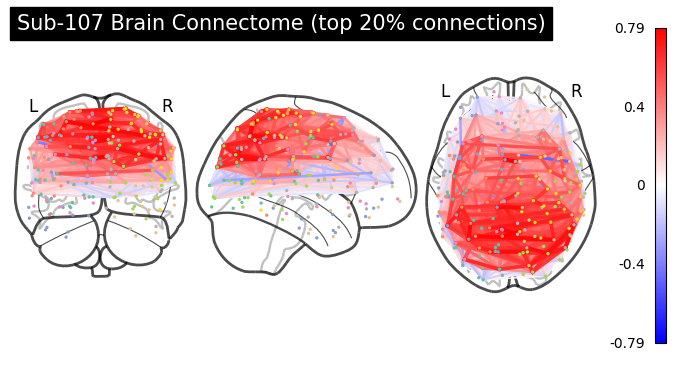

In [8]:
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

# Load your connectivity matrix
matrix_file = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
matrix = np.load(matrix_file)

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = [label.decode() if isinstance(label, bytes) else label for label in atlas.labels]

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Plot matrix dimensions with clear ticks
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
plt.colorbar()

# Add ticks every 50 positions
tick_spacing = 50
ticks = np.arange(0, matrix.shape[0], tick_spacing)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)

plt.title(f"Sub-107 Correlation Matrix Shape: {matrix.shape}")
plt.grid(True)
plt.show()

# Create connectome plot
plt.figure(figsize=(10, 10))
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold="0%",  # Keep top 20% of connections
    node_color='auto',
    node_size=2,
    title="Sub-107 Brain Connectome (top 20% connections)",
    colorbar=True
)

# Create an interactive visualization
view = plotting.view_connectome(
    matrix,
    coords,
    edge_threshold="0%",
    node_color='auto',
    node_size=2
)

# Open the interactive plot in a browser
view.open_in_browser()

# Print some statistics about the connectivity
total_connections = (len(matrix) * (len(matrix) - 1)) / 2  # Total possible connections
threshold = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 20)
strong_connections = np.sum(np.abs(matrix) > threshold) / 2  # Divide by 2 to not count connections twice

print(f"\nConnectivity Statistics for Sub-107:")
print(f"Number of regions: {len(matrix)}")
print(f"Total possible connections: {int(total_connections)}")
print(f"Connections above 80th percentile threshold ({threshold:.3f}): {int(strong_connections)}")
print(f"Percentage of strong connections: {(strong_connections/total_connections)*100:.2f}%")

plt.show()

Coordinate Ranges:
X range: -61.0 to 63.7
Y range: -96.8 to 64.5
Z range: -38.6 to 70.3


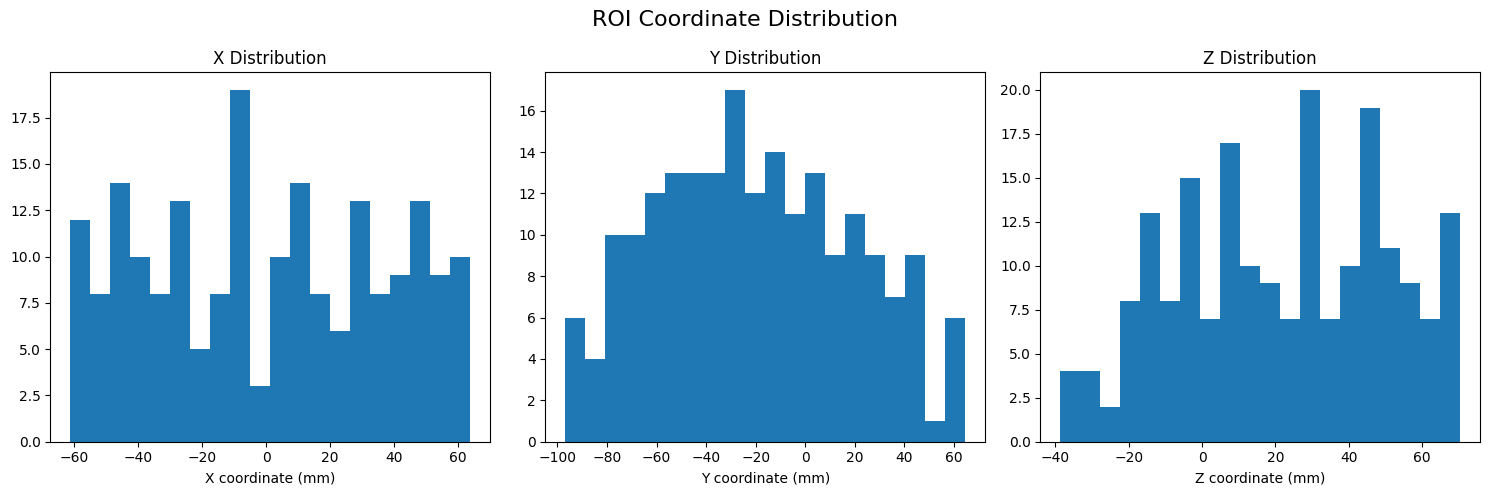

/tmp/ipykernel_20368/2474018034.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


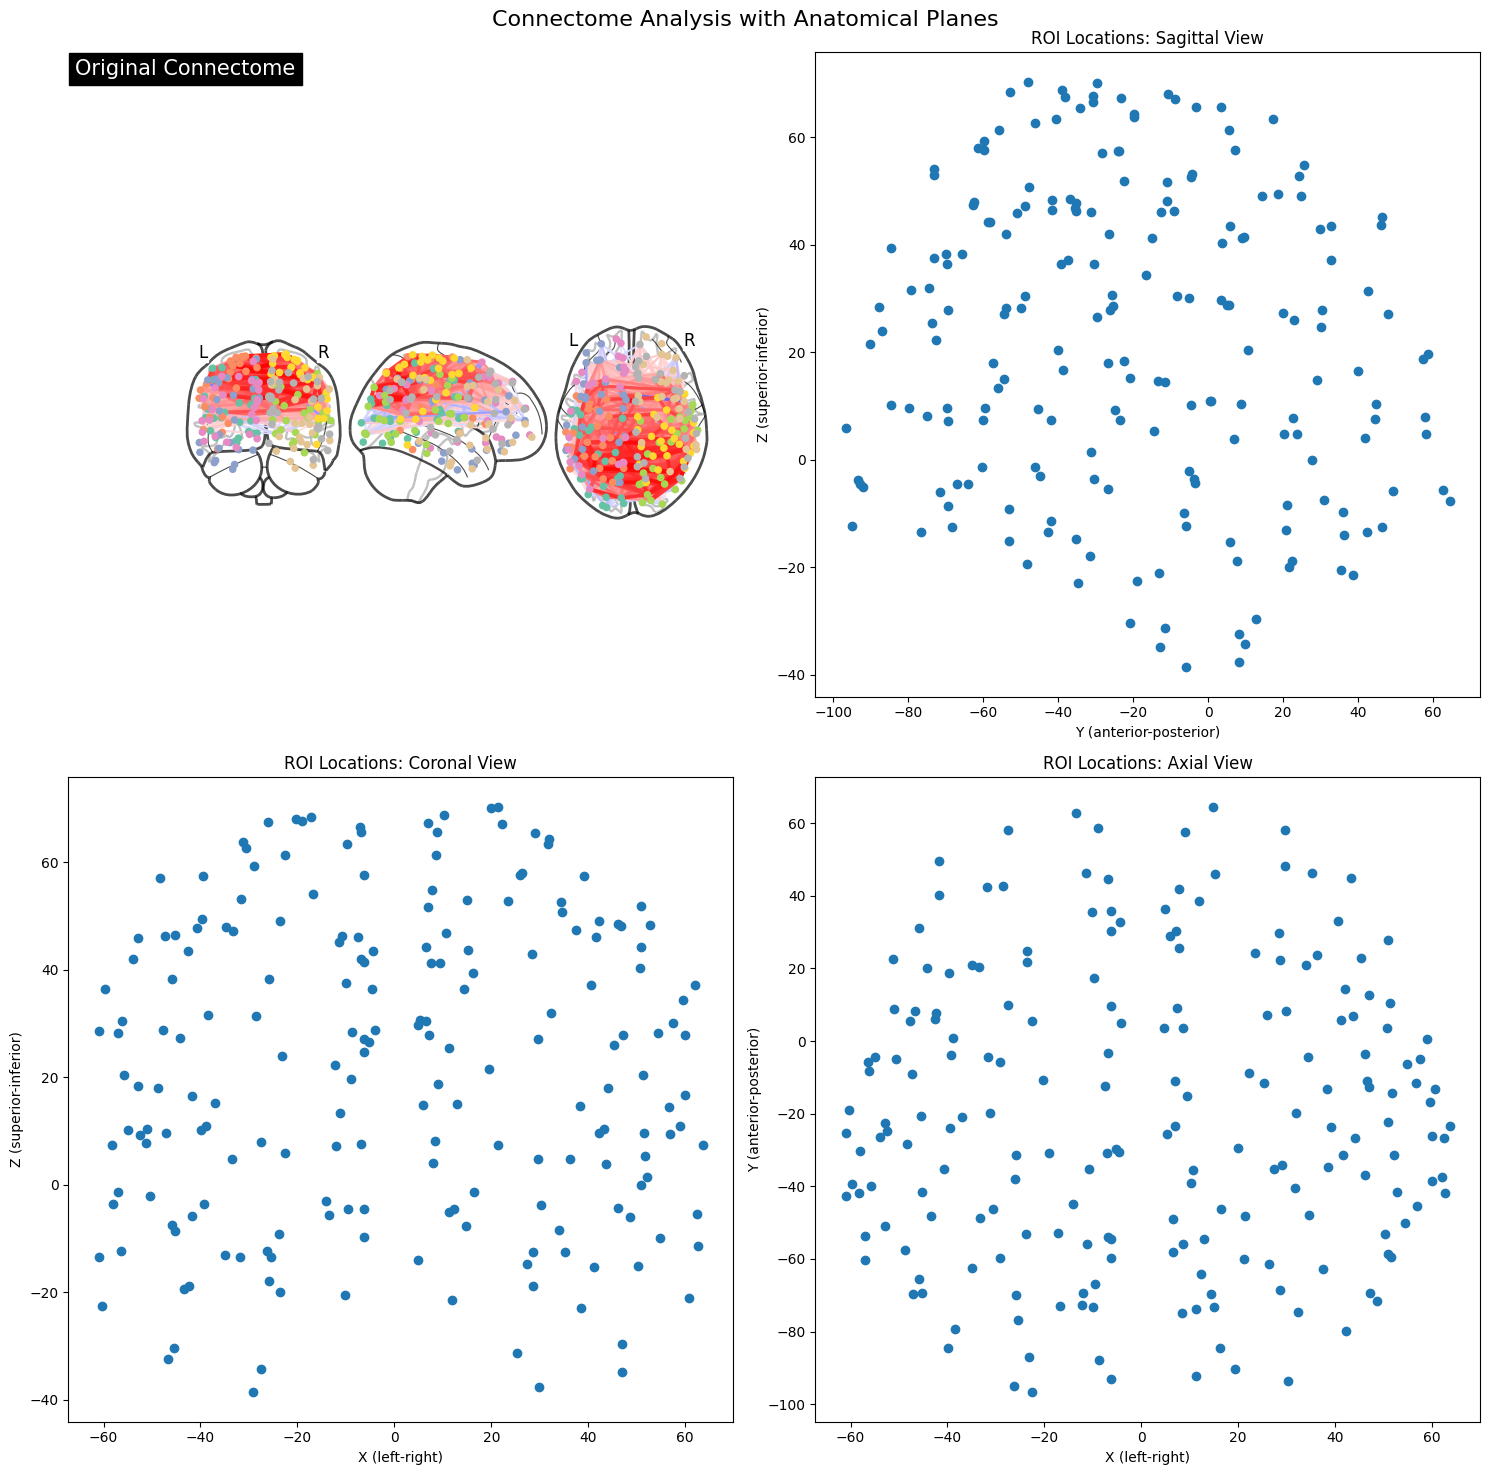


Atlas Coverage Analysis:
Total voxels in atlas: 902629
Non-zero voxels: 132032
Coverage percentage: 14.63%

Z-axis coverage range: 11 to 76 (out of 91)


In [17]:
# Cell 1: Import libraries
import numpy as np
from nilearn import datasets, plotting, image
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib
import os

# Cell 2: Load and check data
subject = "sub-107"
matrix_file = f"/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/{subject}_connectivity_matrix_standard.npy"

# Load matrix
matrix = np.load(matrix_file)

# Load atlas with explicit checking
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = nib.load(atlas.maps)

# Get and inspect coordinates
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Print coordinate ranges for inspection
print("Coordinate Ranges:")
print(f"X range: {coords[:, 0].min():.1f} to {coords[:, 0].max():.1f}")
print(f"Y range: {coords[:, 1].min():.1f} to {coords[:, 1].max():.1f}")
print(f"Z range: {coords[:, 2].min():.1f} to {coords[:, 2].max():.1f}")

# Cell 3: Create validation visualization
def plot_coordinate_distribution(coords):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('ROI Coordinate Distribution', fontsize=16)
    
    # Plot distribution of coordinates in each dimension
    axes[0].hist(coords[:, 0], bins=20)
    axes[0].set_title('X Distribution')
    axes[0].set_xlabel('X coordinate (mm)')
    
    axes[1].hist(coords[:, 1], bins=20)
    axes[1].set_title('Y Distribution')
    axes[1].set_xlabel('Y coordinate (mm)')
    
    axes[2].hist(coords[:, 2], bins=20)
    axes[2].set_title('Z Distribution')
    axes[2].set_xlabel('Z coordinate (mm)')
    
    plt.tight_layout()
    return fig

# Plot coordinate distributions
plot_coordinate_distribution(coords)
plt.show()

# Cell 4: Create modified connectome visualization
def plot_connectome_with_planes(matrix, coords):
    """Plot connectome with additional anatomical plane indicators"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Connectome Analysis with Anatomical Planes', fontsize=16)
    
    # Original connectome
    plotting.plot_connectome(
        matrix,
        coords,
        edge_threshold='80%',
        node_color='auto',
        node_size=20,
        display_mode='ortho',
        axes=axes[0, 0],
        title="Original Connectome"
    )
    
    # Scatter plots of ROI locations
    # Sagittal view (Y-Z)
    axes[0, 1].scatter(coords[:, 1], coords[:, 2])
    axes[0, 1].set_xlabel('Y (anterior-posterior)')
    axes[0, 1].set_ylabel('Z (superior-inferior)')
    axes[0, 1].set_title('ROI Locations: Sagittal View')
    
    # Coronal view (X-Z)
    axes[1, 0].scatter(coords[:, 0], coords[:, 2])
    axes[1, 0].set_xlabel('X (left-right)')
    axes[1, 0].set_ylabel('Z (superior-inferior)')
    axes[1, 0].set_title('ROI Locations: Coronal View')
    
    # Axial view (X-Y)
    axes[1, 1].scatter(coords[:, 0], coords[:, 1])
    axes[1, 1].set_xlabel('X (left-right)')
    axes[1, 1].set_ylabel('Y (anterior-posterior)')
    axes[1, 1].set_title('ROI Locations: Axial View')
    
    plt.tight_layout()
    return fig

# Create validation plots
plot_connectome_with_planes(matrix, coords)
plt.show()

# Cell 5: Check atlas coverage
def check_atlas_coverage():
    """Check the coverage of the atlas in the brain"""
    atlas_data = atlas_img.get_fdata()
    
    # Get non-zero voxel coordinates
    nonzero_coords = np.where(atlas_data > 0)
    
    print("\nAtlas Coverage Analysis:")
    print(f"Total voxels in atlas: {np.prod(atlas_data.shape)}")
    print(f"Non-zero voxels: {len(nonzero_coords[0])}")
    print(f"Coverage percentage: {(len(nonzero_coords[0])/np.prod(atlas_data.shape))*100:.2f}%")
    
    # Check z-axis coverage
    z_coverage = np.any(atlas_data > 0, axis=(0,1))
    z_range = np.where(z_coverage)[0]
    print(f"\nZ-axis coverage range: {z_range[0]} to {z_range[-1]} (out of {atlas_data.shape[2]})")

# Run atlas coverage check
check_atlas_coverage()

/tmp/ipykernel_20368/2227941079.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


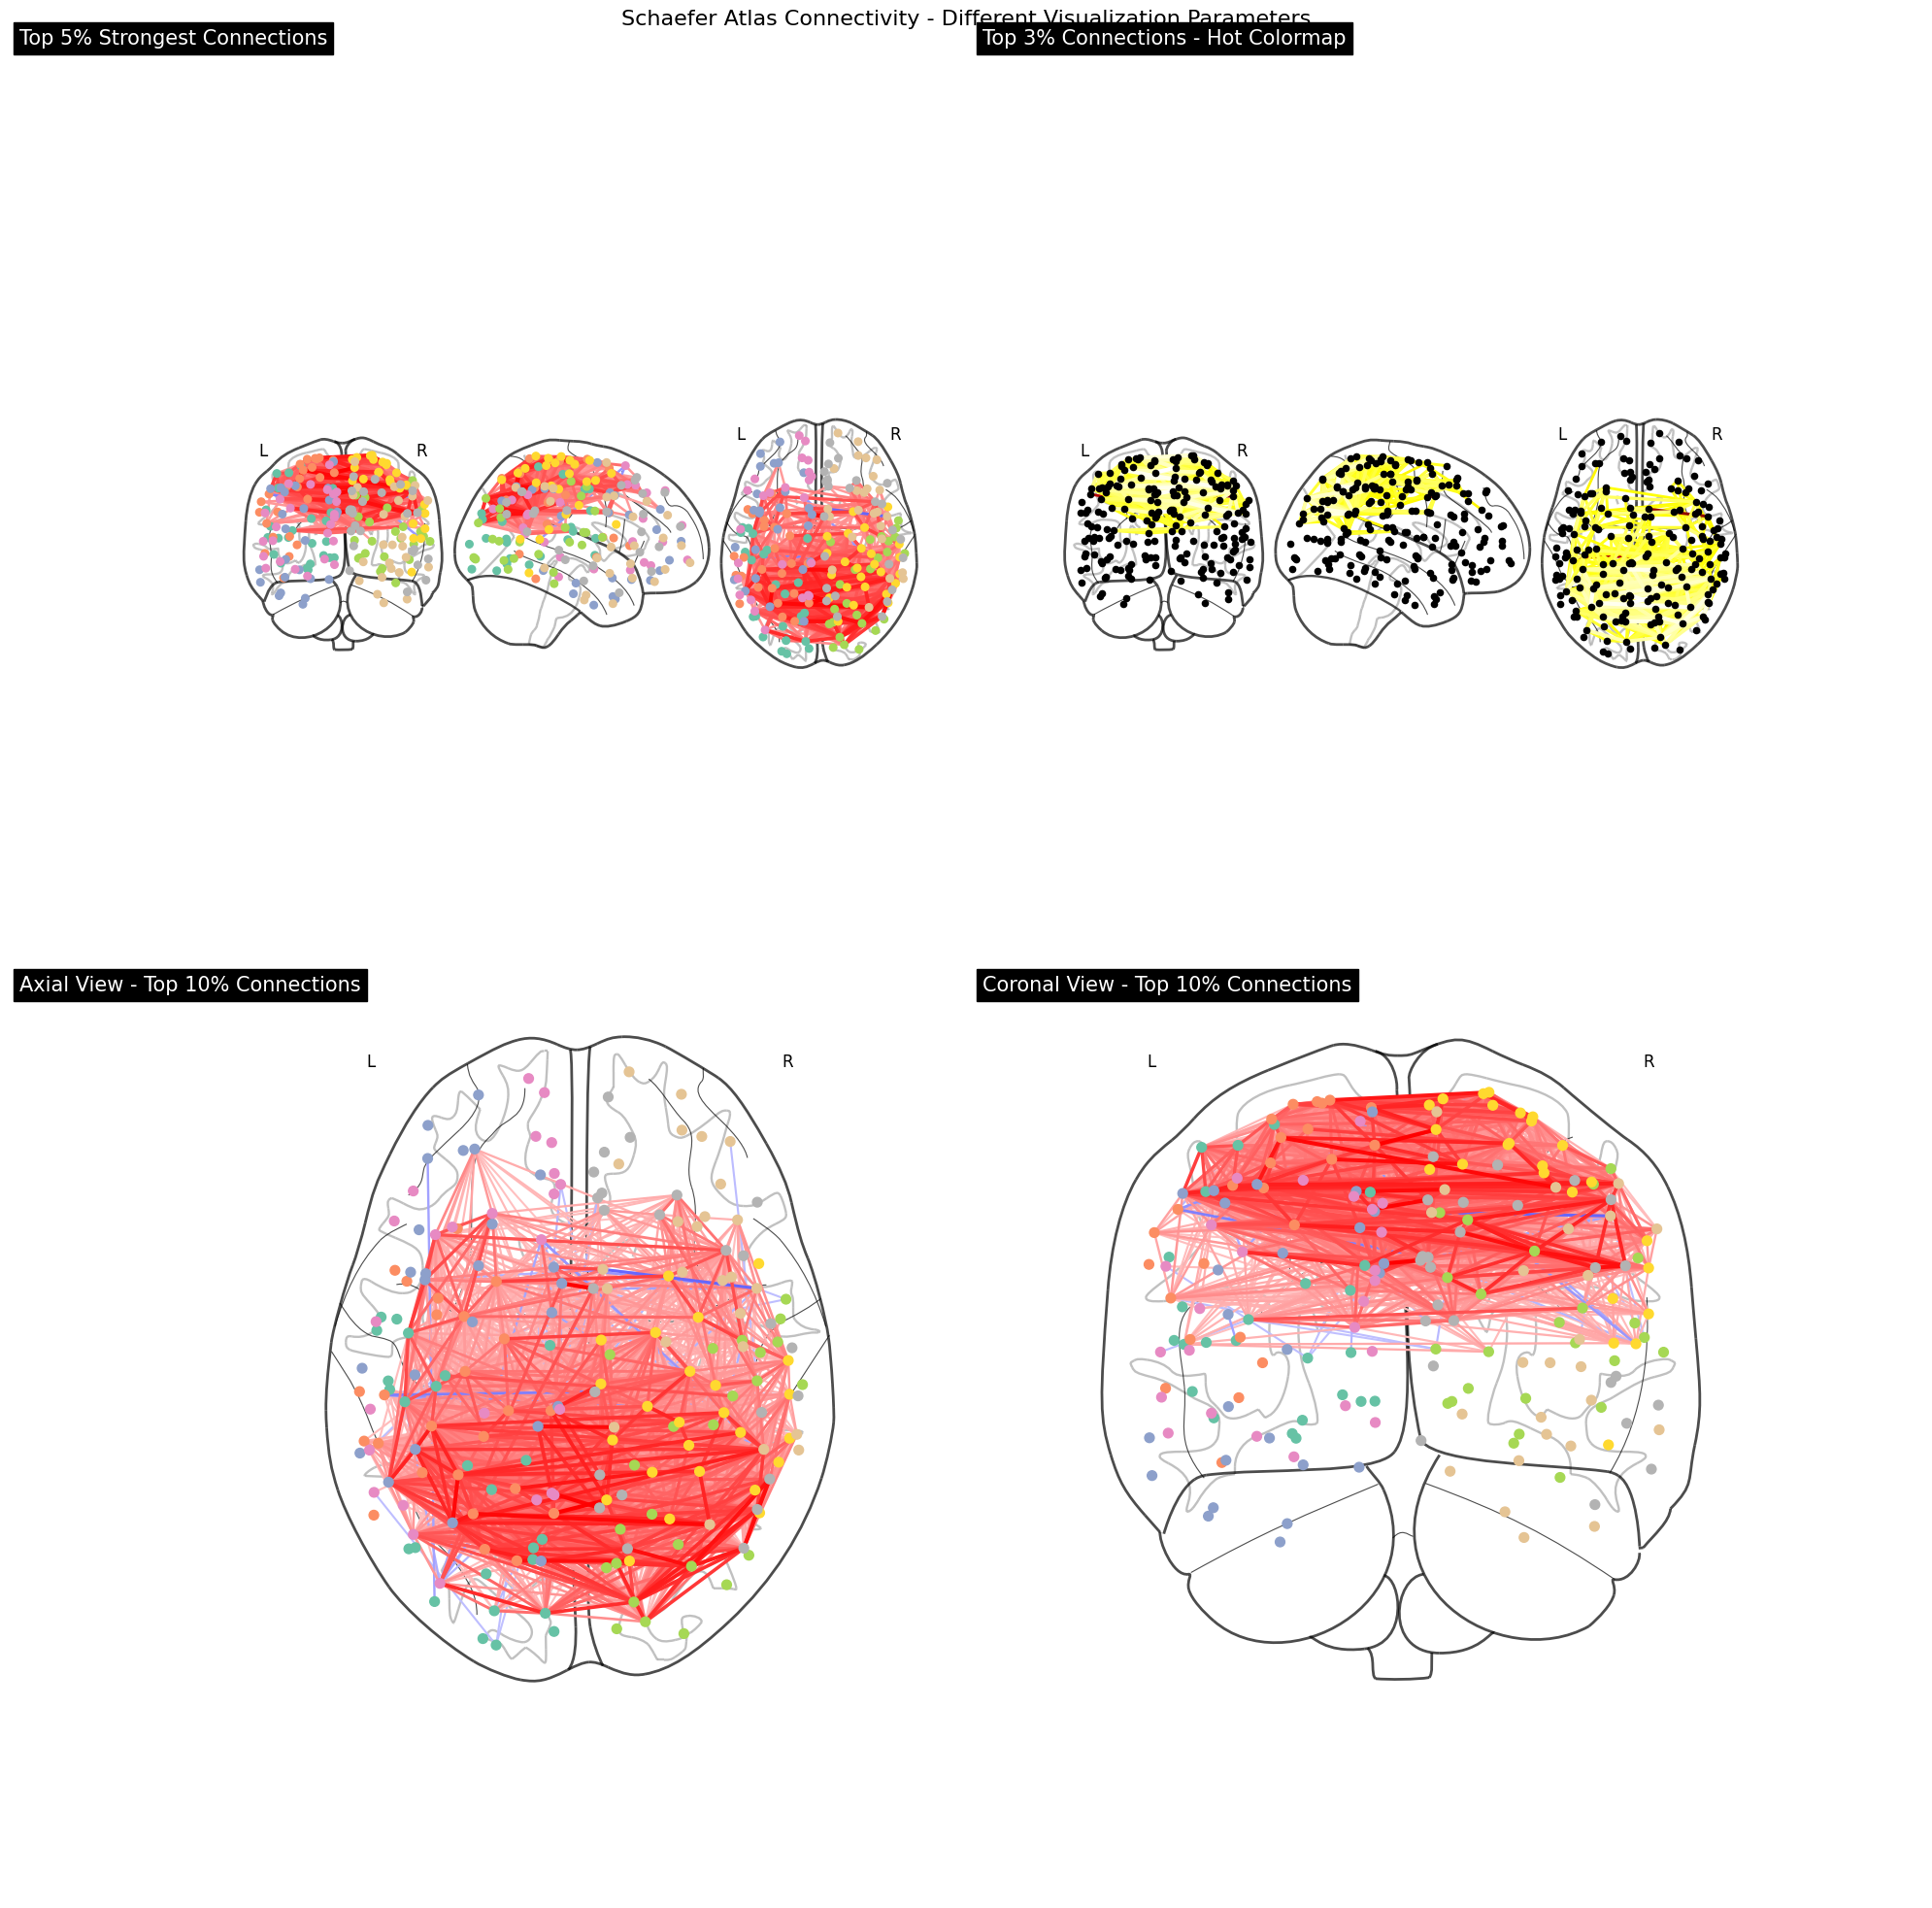


Connection Threshold Analysis:

At 90.0% threshold:
Correlation threshold value: 0.194
Number of connections shown: 2090
Percentage of total possible connections: 10.50%

At 95.0% threshold:
Correlation threshold value: 0.297
Number of connections shown: 1095
Percentage of total possible connections: 5.50%

At 97.0% threshold:
Correlation threshold value: 0.369
Number of connections shown: 697
Percentage of total possible connections: 3.50%


In [27]:
# Cell 1: Improved connectome visualization
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt

# Load your connectivity matrix
matrix_file = "/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy"
matrix = np.load(matrix_file)

# Load Schaefer atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
coords = plotting.find_parcellation_cut_coords(schaefer_atlas.maps)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Schaefer Atlas Connectivity - Different Visualization Parameters', fontsize=16)

# Plot 1: Standard view with different threshold
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='95%',  # Show only top 5% strongest connections
    node_color='auto',
    node_size=30,  # Larger nodes
    display_mode='ortho',
    axes=axes[0, 0],
    title="Top 5% Strongest Connections"
)

# Plot 2: Different colormap and edge threshold
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='97%',  # Even more selective
    edge_cmap='hot',  # Different colormap
    node_color='k',  # Black nodes
    node_size=20,
    display_mode='ortho',
    axes=axes[0, 1],
    title="Top 3% Connections - Hot Colormap"
)

# Plot 3: Single view with more connections
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='90%',
    node_color='auto',
    node_size=50,  # Even larger nodes
    display_mode='z',  # Only axial view
    axes=axes[1, 0],
    title="Axial View - Top 10% Connections"
)

# Plot 4: Another single view
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold='90%',
    node_color='auto',
    node_size=50,
    display_mode='y',  # Coronal view
    axes=axes[1, 1],
    title="Coronal View - Top 10% Connections"
)

plt.tight_layout()
plt.show()

# Print some statistics about the connections being shown
thresholds = [0.90, 0.95, 0.97]
print("\nConnection Threshold Analysis:")
for thresh in thresholds:
    thresh_value = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 
                               thresh * 100)
    n_connections = np.sum(np.abs(matrix) > thresh_value) // 2  # Divide by 2 because matrix is symmetric
    print(f"\nAt {thresh*100}% threshold:")
    print(f"Correlation threshold value: {thresh_value:.3f}")
    print(f"Number of connections shown: {n_connections}")
    print(f"Percentage of total possible connections: {(n_connections/(len(matrix)*(len(matrix)-1)/2))*100:.2f}%")

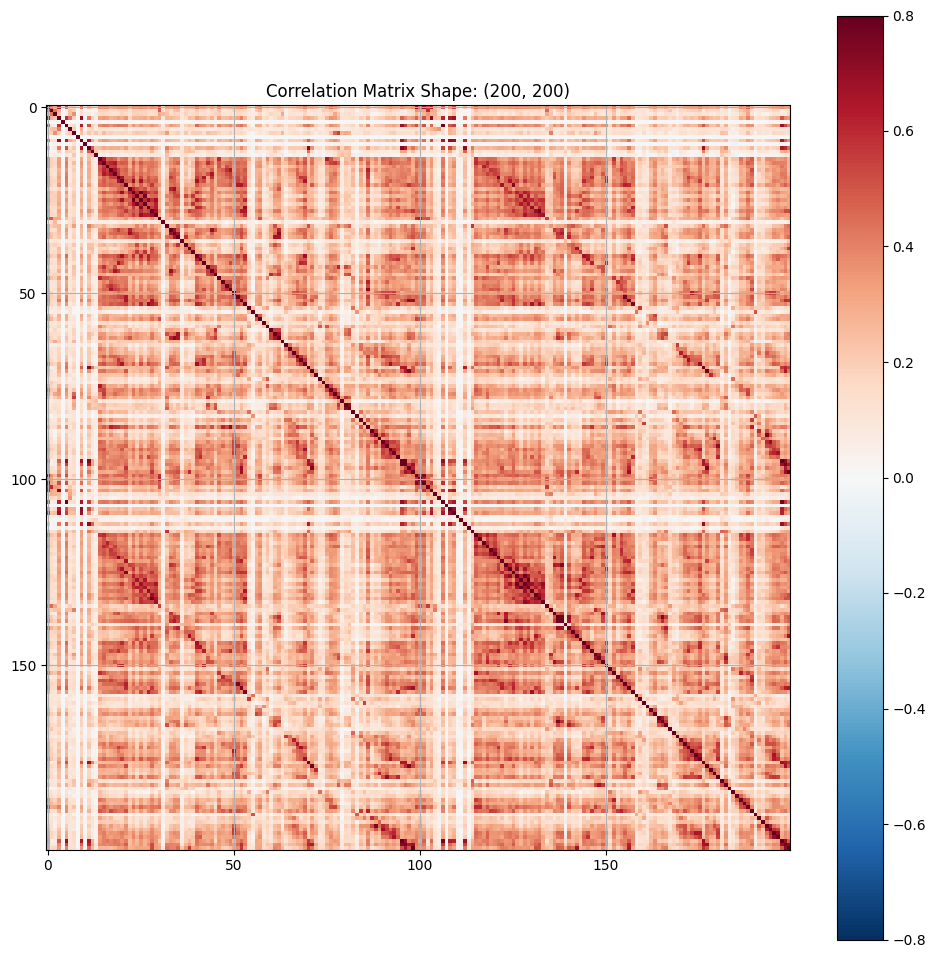


Connectivity Statistics:
Number of regions: 200
Total possible connections: 19900
Connections above 80th percentile threshold (0.366): 4080
Percentage of strong connections: 20.50%


<Figure size 1000x1000 with 0 Axes>

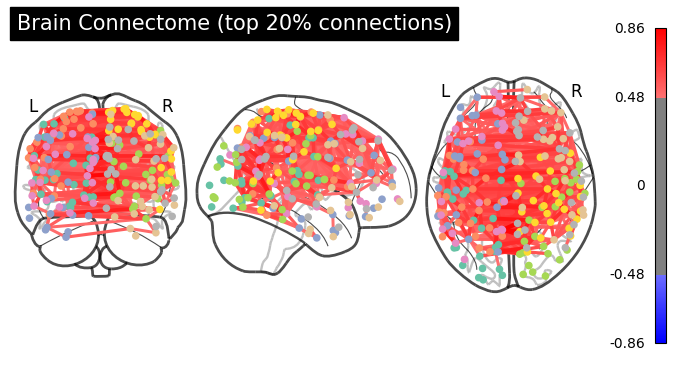

In [ ]:
#nilearn plotting
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = [label.decode() if isinstance(label, bytes) else label for label in atlas.labels]

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Plot matrix dimensions with clear ticks
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
plt.colorbar()

# Add ticks every 50 positions
tick_spacing = 50
ticks = np.arange(0, matrix.shape[0], tick_spacing)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)

plt.title(f"Correlation Matrix Shape: {matrix.shape}")
plt.grid(True)
plt.show()

# Create connectome plot
plt.figure(figsize=(10, 10))
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold="80%",  # Keep top 20% of connections
    node_color='auto',
    node_size=20,
    title="Brain Connectome (top 20% connections)",
    colorbar=True
)

# Create an interactive visualization
view = plotting.view_connectome(
    matrix,
    coords,
    edge_threshold="80%",
    node_color='auto',
    node_size=20
)

# Open the interactive plot in a browser
view.open_in_browser()

# Print some statistics about the connectivity
total_connections = (len(matrix) * (len(matrix) - 1)) / 2  # Total possible connections
threshold = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 80)
strong_connections = np.sum(np.abs(matrix) > threshold) / 2  # Divide by 2 to not count connections twice

print(f"\nConnectivity Statistics:")
print(f"Number of regions: {len(matrix)}")
print(f"Total possible connections: {int(total_connections)}")
print(f"Connections above 80th percentile threshold ({threshold:.3f}): {int(strong_connections)}")
print(f"Percentage of strong connections: {(strong_connections/total_connections)*100:.2f}%")

plt.show()

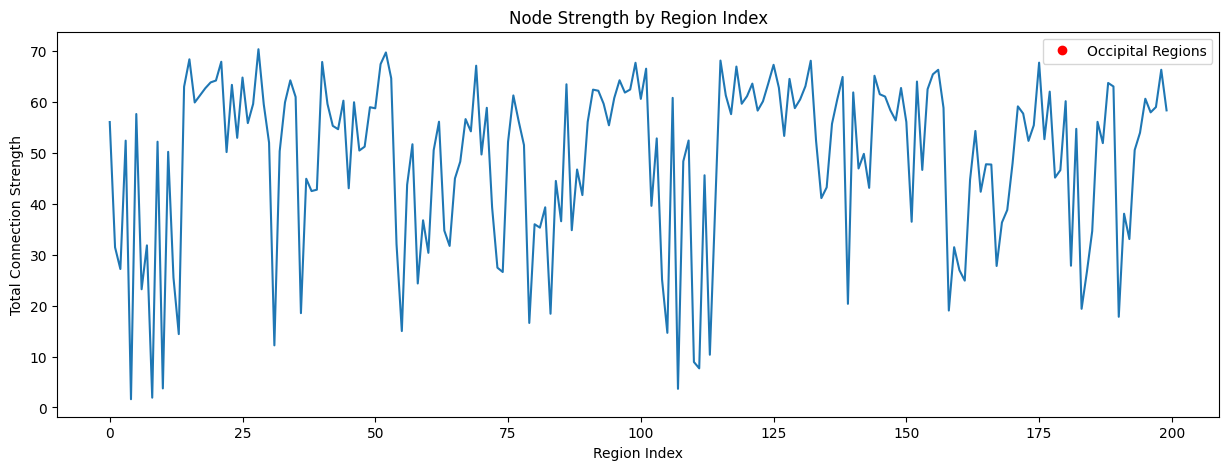

In [21]:
# Add regional connectivity strength analysis
node_strength = np.sum(np.abs(matrix), axis=0)

# Plot strength by region
plt.figure(figsize=(15, 5))
plt.plot(node_strength)
plt.title("Node Strength by Region Index")
plt.xlabel("Region Index")
plt.ylabel("Total Connection Strength")

# Add markers for occipital regions
plt.plot(occipital_indices, node_strength[occipital_indices], 'ro', label='Occipital Regions')
plt.legend()
plt.show()

Occipital connectivity stats:
Number of occipital regions: 0
Mean connectivity: nan
% of zero values: nan%
% of NaN values: nan%


/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_20368/3235755903.py:9: RuntimeWarning: invalid value encountered in scalar divide
  print(f"% of zero values: {np.sum(occipital_connectivity == 0) / occipital_connectivity.size * 100}%")
/tmp/ipykernel_20368/3235755903.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"% of NaN values: {np.sum(np.isnan(occipital_connectivity)) / occipital_connectivity.size * 100}%")
/tmp/ipykernel_20368/3235755903.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(occipital_connectivity, cmap='RdBu_r')
/tmp/ipykernel_

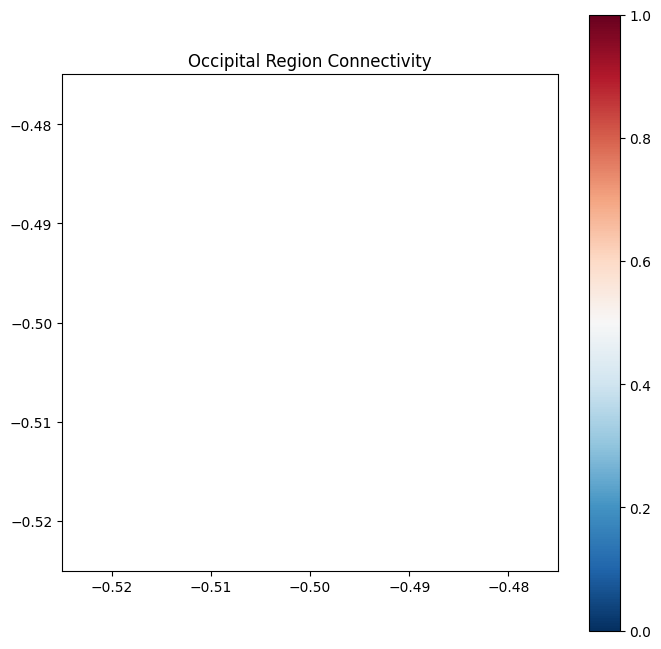

In [19]:
# Add these checks to your script
# Check for NaN or zero values in occipital regions
occipital_indices = [i for i, label in enumerate(labels) if 'Visual' in label]
occipital_connectivity = matrix[occipital_indices][:, occipital_indices]

print("Occipital connectivity stats:")
print(f"Number of occipital regions: {len(occipital_indices)}")
print(f"Mean connectivity: {np.mean(occipital_connectivity)}")
print(f"% of zero values: {np.sum(occipital_connectivity == 0) / occipital_connectivity.size * 100}%")
print(f"% of NaN values: {np.sum(np.isnan(occipital_connectivity)) / occipital_connectivity.size * 100}%")

# Visualize just the occipital subnetwork
plt.figure(figsize=(8, 8))
plt.imshow(occipital_connectivity, cmap='RdBu_r')
plt.title("Occipital Region Connectivity")
plt.colorbar()
plt.show()

In [23]:
# Print the first few labels to see their format
print("Sample of atlas labels:")
for i, label in enumerate(labels[:10]):
    print(f"{i}: {label}")

# Print unique network names in the labels
unique_networks = set()
for label in labels:
    # Split the label and add the network name
    parts = label.split('_')
    if len(parts) > 1:
        unique_networks.add(parts[1])  # Usually network name is the second part

print("\nUnique networks found in labels:")
for network in sorted(unique_networks):
    print(network)

# Count regions per network
network_counts = {}
for label in labels:
    parts = label.split('_')
    if len(parts) > 1:
        network = parts[1]
        network_counts[network] = network_counts.get(network, 0) + 1

print("\nNumber of regions per network:")
for network, count in network_counts.items():
    print(f"{network}: {count} regions")

Sample of atlas labels:
0: 7Networks_LH_Vis_1
1: 7Networks_LH_Vis_2
2: 7Networks_LH_Vis_3
3: 7Networks_LH_Vis_4
4: 7Networks_LH_Vis_5
5: 7Networks_LH_Vis_6
6: 7Networks_LH_Vis_7
7: 7Networks_LH_Vis_8
8: 7Networks_LH_Vis_9
9: 7Networks_LH_Vis_10

Unique networks found in labels:
LH
RH

Number of regions per network:
LH: 100 regions
RH: 100 regions



Number of visual regions found: 29

Visual region labels:
7Networks_LH_Vis_1
7Networks_LH_Vis_2
7Networks_LH_Vis_3
7Networks_LH_Vis_4
7Networks_LH_Vis_5
7Networks_LH_Vis_6
7Networks_LH_Vis_7
7Networks_LH_Vis_8
7Networks_LH_Vis_9
7Networks_LH_Vis_10
7Networks_LH_Vis_11
7Networks_LH_Vis_12
7Networks_LH_Vis_13
7Networks_LH_Vis_14
7Networks_RH_Vis_1
7Networks_RH_Vis_2
7Networks_RH_Vis_3
7Networks_RH_Vis_4
7Networks_RH_Vis_5
7Networks_RH_Vis_6
7Networks_RH_Vis_7
7Networks_RH_Vis_8
7Networks_RH_Vis_9
7Networks_RH_Vis_10
7Networks_RH_Vis_11
7Networks_RH_Vis_12
7Networks_RH_Vis_13
7Networks_RH_Vis_14
7Networks_RH_Vis_15

Visual network connectivity stats:
Mean connectivity: 0.201
Min connectivity: -0.041
Max connectivity: 1.000


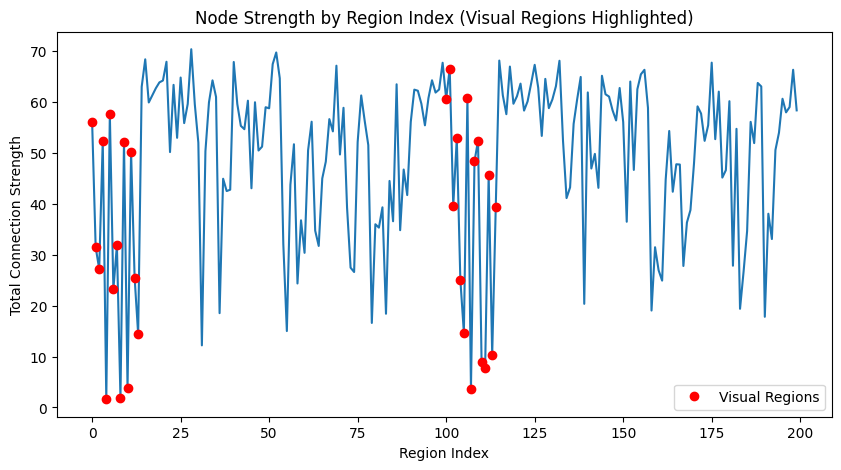

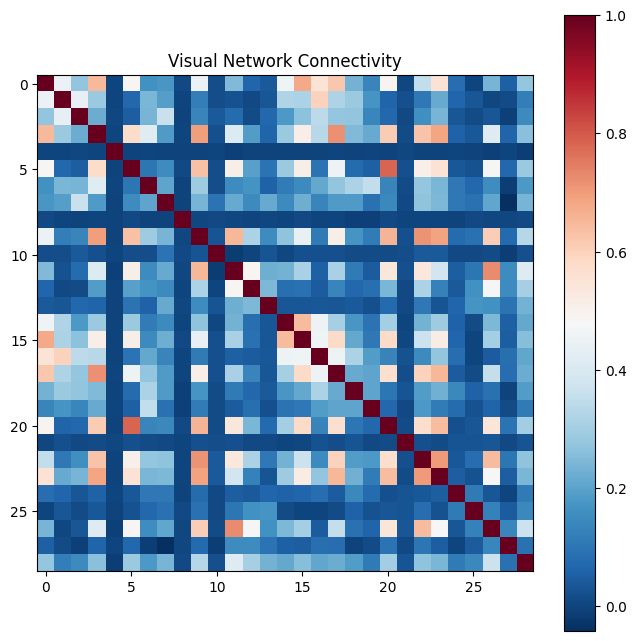

In [24]:
# Correct identification of visual regions
occipital_indices = [i for i, label in enumerate(labels) if '_Vis_' in label]
print(f"\nNumber of visual regions found: {len(occipital_indices)}")

# Print the actual visual region labels to verify
print("\nVisual region labels:")
for idx in occipital_indices:
    print(f"{labels[idx]}")

# Calculate connectivity stats for visual regions
if len(occipital_indices) > 0:
    occipital_connectivity = matrix[occipital_indices][:, occipital_indices]
    print("\nVisual network connectivity stats:")
    print(f"Mean connectivity: {np.mean(occipital_connectivity):.3f}")
    print(f"Min connectivity: {np.min(occipital_connectivity):.3f}")
    print(f"Max connectivity: {np.max(occipital_connectivity):.3f}")
    
    # Plot node strength specifically for visual regions
    plt.figure(figsize=(10, 5))
    plt.plot(node_strength)
    plt.plot(occipital_indices, node_strength[occipital_indices], 'ro', label='Visual Regions')
    plt.title("Node Strength by Region Index (Visual Regions Highlighted)")
    plt.xlabel("Region Index")
    plt.ylabel("Total Connection Strength")
    plt.legend()
    plt.show()

    # Visualize the visual network connectivity matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(occipital_connectivity, cmap='RdBu_r')
    plt.title("Visual Network Connectivity")
    plt.colorbar()
    plt.show()

In [26]:
# Calculate mean connectivity for each network
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
for network in networks:
    network_indices = [i for i, label in enumerate(labels) if f'_{network}_' in label]
    if network_indices:
        network_connectivity = matrix[network_indices][:, network_indices]
        print(f"{network} network mean connectivity: {np.mean(network_connectivity):.3f}")

Vis network mean connectivity: 0.201
SomMot network mean connectivity: 0.465
DorsAttn network mean connectivity: 0.322
SalVentAttn network mean connectivity: 0.393
Limbic network mean connectivity: 0.260
Cont network mean connectivity: 0.297
Default network mean connectivity: 0.265
